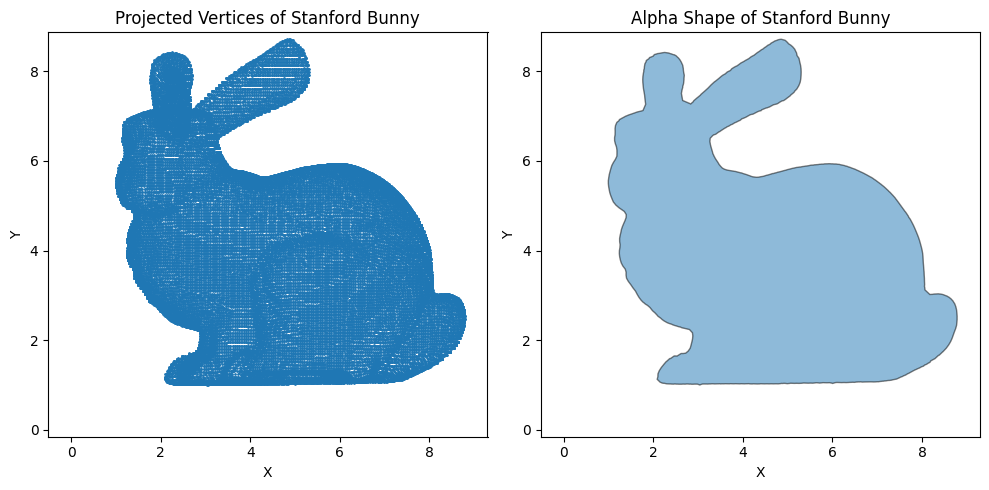

In [127]:
import trimesh
import torch
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import alphashape

bunny = trimesh.load("Resources/stanford-bunny.obj")
vertices_2d = bunny.vertices[:, :2] * 50# Take only X and Y coordinates

#shift vertices to positive values
min_x = np.min(vertices_2d[:, 0])
min_y = np.min(vertices_2d[:, 1])
vertices_2d[:, 0] -= min_x-1
vertices_2d[:, 1] -= min_y-1


#print(vertices_2d)
#vertices_2d = vertices_2d * 30

alpha_shape = alphashape.alphashape(vertices_2d, 10)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(*zip(*vertices_2d), s=1, label="Projected Vertices")
axs[0].set_title("Projected Vertices of Stanford Bunny")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].axis("equal")
axs[0].set_xlim(-1, np.max(vertices_2d[:, 0])+1)
axs[0].set_ylim(-1, np.max(vertices_2d[:, 1])+1)

#axs[1].scatter(*zip(*vertices_2d))
axs[1].add_patch(PolygonPatch(alpha_shape, alpha=0.5))
axs[1].set_title("Alpha Shape of Stanford Bunny")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].axis("equal")
axs[1].set_xlim(-1, np.max(vertices_2d[:, 0])+1)
axs[1].set_ylim(-1, np.max(vertices_2d[:, 1])+1)

# axs[1].set_xlim(-10, 20)
# axs[1].set_ylim(-10, 20)

# Show the figure
plt.tight_layout()
plt.show()


In [128]:
def bunny_sdf(vertices):
    import trimesh
    import alphashape
    from shapely.geometry import Point, LineString    
    # Ray-casting to determine if the point is inside or outside
    def ray_casting(point, shape):
        import numpy as np
        from shapely.geometry import LineString, MultiLineString

        ray_length = 1000  # Length of the ray
        # Define all directions as a NumPy array
        directions = np.array([
            [ray_length, 0],   # Positive X
            [-ray_length, 0],  # Negative X
            [0, ray_length],   # Positive Y
            [0, -ray_length],  # Negative Y
            [ray_length, ray_length],  # Diagonal top-right
            [-ray_length, -ray_length]  # Diagonal bottom-left
        ])

        rays = [LineString([point, point + direction]) for direction in directions]

        intersections = [shape.boundary.intersection(ray) for ray in rays]

        # Compute the number of intersections for each ray
        intersection_counts = []
        for intersection in intersections:
            if intersection.geom_type == "Point":
                intersection_counts.append(1)
            elif intersection.geom_type == "MultiPoint":
                intersection_counts.append(len(intersection.geoms))
            else:  # No valid intersection
                intersection_counts.append(0)

        # Return the maximum number of intersections across all rays
        highest_intersections = max(intersection_counts)
        return highest_intersections
        
    bunny = trimesh.load("Resources/stanford-bunny.obj")
    bunny_2dvertices = bunny.vertices[:, :2] * 50 # Take only X and Y coordinates
    
    #shift vertices to positive values
    min_x = np.min(bunny_2dvertices[:, 0])
    min_y = np.min(bunny_2dvertices[:, 1])
    bunny_2dvertices[:, 0] -= min_x-1
    bunny_2dvertices[:, 1] -= min_y-1

    alpha_shape = alphashape.alphashape(bunny_2dvertices, 10)

    sdf_values = torch.zeros(vertices.shape[0])

    # Compute the signed distance for each vertices
    for i, point in enumerate(vertices):
        point_shapely = Point(point[0], point[1])
        
        # Compute the shortest distance to the boundary
        distance_to_boundary = point_shapely.distance(alpha_shape.boundary)
        
        # Use ray-casting to determine if the point is inside or outside
        if ray_casting(point, alpha_shape) % 2 == 1:
            sdf_values[i] = -distance_to_boundary  # Inside, negative distance
        else:
            sdf_values[i] = distance_to_boundary  # Outside, positive distance


    return sdf_values



tensor([[20.8519, 20.8316, 20.8113,  ..., 17.5829, 17.5984, 17.6139],
        [20.8299, 20.8096, 20.7893,  ..., 17.5572, 17.5727, 17.5883],
        [20.8079, 20.7876, 20.7673,  ..., 17.5315, 17.5471, 17.5627],
        ...,
        [17.3117, 17.2866, 17.2615,  ..., 15.2095, 15.2270, 15.2444],
        [17.3279, 17.3029, 17.2778,  ..., 15.2339, 15.2513, 15.2688],
        [17.3442, 17.3191, 17.2941,  ..., 15.2584, 15.2757, 15.2932]])
torch.Size([1024, 1024])


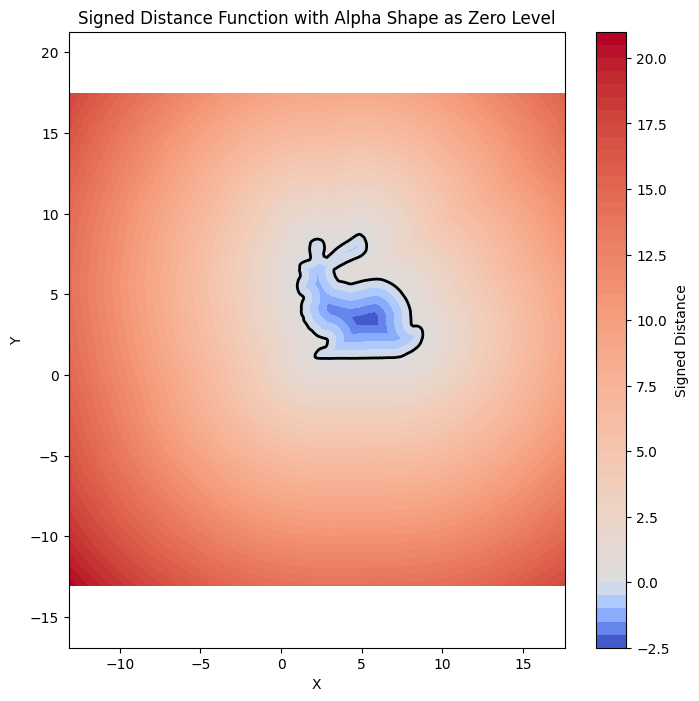

In [129]:
import matplotlib
import os
import numpy as np
import torch

# Grid size
gridsize = 1024

# Create a grid of points (for example, a 100x100 grid within the bounding box of the alpha shape)
x_min, y_min, x_max, y_max = alpha_shape.bounds# Assuming `alpha_shape` is already defined

x_min = x_max*-1.5
y_min = y_max*-1.5
x_max = x_max*2
y_max = y_max*2

grid_x, grid_y = torch.meshgrid(
    torch.linspace(x_min, x_max, gridsize),
    torch.linspace(y_min, y_max, gridsize),
    indexing="ij"  # Match the shape of `meshgrid` in NumPy
)

# Flatten the grid to create input points
grid_points = torch.stack([grid_x.ravel(), grid_y.ravel()], dim=1)  # Shape: (gridsize^2, 2)


# Example: Compute signed distance for the grid points
sdf_grid_path = f"sdf_grid_{gridsize}.pt"

if not os.path.exists(sdf_grid_path):
    sdf_values = bunny_sdf(grid_points)
    # Reshape the SDF values back to the grid for visualization
    sdf_grid = sdf_values.view(gridsize, gridsize)
    torch.save(sdf_grid, sdf_grid_path)
else:
    sdf_grid = torch.load(sdf_grid_path)


print(sdf_grid)
print(sdf_grid.shape)

# Optionally, convert to NumPy for plotting
sdf_grid_np = sdf_grid.cpu().numpy()


# Create a figure for visualization
plt.figure(figsize=(8, 8))

# Normalize the signed distances so that zero is the center
#norm = matplotlib.colors.Normalize(vmin=np.min(sdf_grid_np), vmax=-np.min(sdf_grid_np))
norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_grid_np), vcenter=0, vmax=np.max(sdf_grid_np))



# Plot the SDF with the centered colormap
contour = plt.contourf(grid_x, grid_y, sdf_grid_np, levels=50, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")

# Plot the zero level contour in black
plt.contour(grid_x, grid_y, sdf_grid_np, levels=[0], colors='black', linewidths=2)



# Set the plot title and labels
plt.title("Signed Distance Function with Alpha Shape as Zero Level")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")

# Show the plot
plt.show()

tensor([[20.8519, 20.6433, 20.4371,  ..., 17.3003, 17.4551, 17.6139],
        [20.6256, 20.4146, 20.2062,  ..., 17.0313, 17.1885, 17.3497],
        [20.4014, 20.1881, 19.9773,  ..., 16.7636, 16.9233, 17.0871],
        ...,
        [17.0159, 16.7526, 16.4908,  ..., 14.4295, 14.6095, 14.7937],
        [17.1780, 16.9172, 16.6580,  ..., 14.6843, 14.8612, 15.0423],
        [17.3442, 17.0859, 16.8293,  ..., 14.9412, 15.1150, 15.2932]])
torch.Size([100, 100])


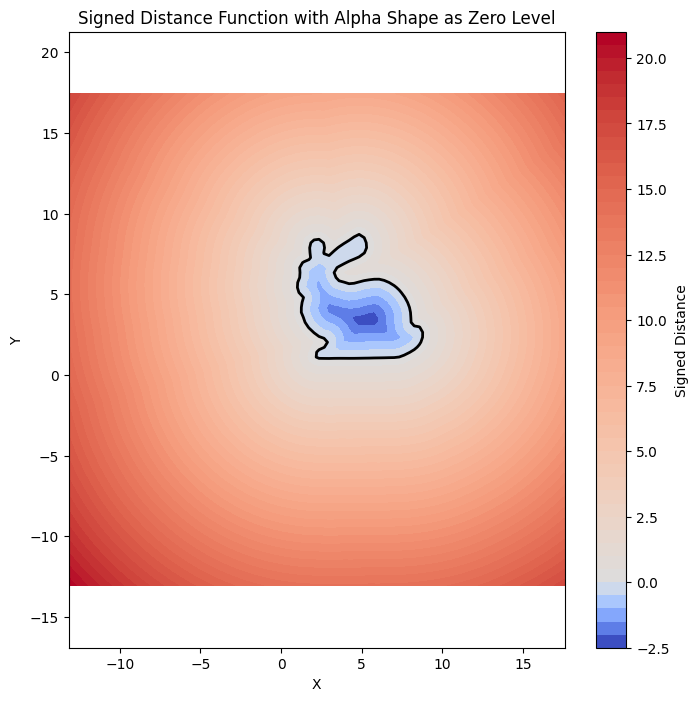

In [130]:
import torch

def interpolate_sdf(grid, points, x_min, y_min, x_max, y_max):
    """
    Interpolate SDF values for given 2D points using a precomputed SDF grid.
    Args:
        grid: SDF grid of shape (gridsize, gridsize).
        points: Input points of shape (N, 2), where each row is (x, y).
        x_min, y_min, x_max, y_max: Bounds of the grid.
    Returns:
        Interpolated SDF values at the input points of shape (N,).
    """
    # Normalize points to [0, 1] range
    points_normalized = (points - torch.tensor([x_min, y_min])) / torch.tensor([x_max - x_min, y_max - y_min])

    # Scale to grid coordinates
    gridsize = grid.shape[0]
    points_grid = points_normalized * (gridsize - 1)

    # Separate grid coordinates into integer and fractional parts
    x = points_grid[:, 0]
    y = points_grid[:, 1]
    x0 = x.floor().long().clamp(0, gridsize - 1)
    y0 = y.floor().long().clamp(0, gridsize - 1)
    x1 = (x0 + 1).clamp(0, gridsize - 1)
    y1 = (y0 + 1).clamp(0, gridsize - 1)
    dx = x - x0
    dy = y - y0

    # Perform bilinear interpolation
    values = (
        (1 - dx) * (1 - dy) * grid[x0, y0] +
        dx * (1 - dy) * grid[x1, y0] +
        (1 - dx) * dy * grid[x0, y1] +
        dx * dy * grid[x1, y1]
    )
    return values

# # Example usage
# points = torch.tensor([[0.1, 0.2], [0.3, 0.4]])  # Example 2D input points
# interpolated_sdf = interpolate_sdf(sdf_grid, points, x_min, y_min, x_max, y_max)
# print(interpolated_sdf)



# Grid size
gridsize = 100

# Create a grid of points (for example, a 100x100 grid within the bounding box of the alpha shape)
x_min, y_min, x_max, y_max = alpha_shape.bounds  # Assuming `alpha_shape` is already defined

x_min = x_max*-1.5
y_min = y_max*-1.5
x_max = x_max*2
y_max = y_max*2

grid_x, grid_y = torch.meshgrid(
    torch.linspace(x_min, x_max, gridsize),
    torch.linspace(y_min, y_max, gridsize),
    indexing="ij"  # Match the shape of `meshgrid` in NumPy
)

# Flatten the grid to create input points
grid_points = torch.stack([grid_x.ravel(), grid_y.ravel()], dim=1)  # Shape: (gridsize^2, 2)




interpolated_sdf = interpolate_sdf(sdf_grid, grid_points, x_min, y_min, x_max, y_max)

# Reshape the SDF values back to the grid for visualization
interpolate_sdf_grid = interpolated_sdf.view(gridsize, gridsize)

print(interpolate_sdf_grid)
print(interpolate_sdf_grid.shape)

# Optionally, convert to NumPy for plotting
sdf_grid_np = interpolate_sdf_grid.cpu().numpy()


# Create a figure for visualization
plt.figure(figsize=(8, 8))

# Normalize the signed distances so that zero is the center
norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_grid_np),vcenter=0, vmax=np.max(sdf_grid_np))

# Plot the SDF with the centered colormap
contour = plt.contourf(grid_x, grid_y, sdf_grid_np, levels=50, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")

# Plot the zero level contour in black
plt.contour(grid_x, grid_y, sdf_grid_np, levels=[0], colors='black', linewidths=2)



# Set the plot title and labels
plt.title("Signed Distance Function with Alpha Shape as Zero Level")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
# Show the plot
plt.show()

In [131]:
print(x_min, y_min, x_max, y_max)

-13.177425 -13.07505 17.5699 17.4334
